In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [6]:
proj_name = "lung_atlas_benchmarking"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'mps'
seed = 0
ccd.ul.set_seed(seed)
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"

In [7]:
data_dir = Path("../data/lung_atlas/")
adata = sc.read(
    data_dir / "Lung_atlas_public.h5ad"
)
batch_key = "batch"
adata


AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [8]:
# Load previous adata.obsm if not computing from scratch
#adata.obsm = ccd.ul.load_obsm_from_hdf5(Path('../save/dev_lung_atlas_benchmarking-Oct10/') / "obsm_lung_atlas_benchmarking_Oct10-1440.h5")
adata.obsm = ccd.ul.load_obsm_from_hdf5(Path('../save/dev_lung_atlas_benchmarking-Feb15/obsm_lung_atlas_benchmarking_Feb15-1545.h5'))

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
show_cols = ['dataset', 'nGene', 'protocol', 'batch', 'donor', 'cell_type']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### No correction

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
show_basis = 'X_umap'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Scanorama

In [ ]:
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)
output_key = 'Scanorama'
adata.obsm[output_key] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm[output_key][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

In [ ]:
output_key = 'Scanorama'
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [ ]:
adata.write_h5ad(save_dir / f"adata_{file_suffix}.h5ad")

In [ ]:
adata = sc.read(save_dir / f"adata_lung_atlas_benchmarking_Oct08-1943.h5ad")

### Liger

In [ ]:
import pyliger
batch_cats = adata.obs.batch.cat.categories
bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)

output_key = 'LIGER'
adata.obsm[output_key] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm[output_key][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

In [ ]:
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Harmony

In [ ]:
from harmony import harmonize
output_key = 'Harmony'
adata.obsm[output_key] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

In [ ]:
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scVI

In [ ]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
output_key = 'scVI'
adata.obsm[output_key] = vae.get_latent_representation()

In [ ]:
output_key = 'scVI'
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scANVI

In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
output_key = 'scANVI'
adata.obsm[output_key] = lvae.get_latent_representation()

In [ ]:
output_key = 'scANVI'
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=6, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Concord

In [10]:
ccd.__version__

'0.9.0'

In [11]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      latent_dim=30,
                      p_intra_knn=0.1,
                      sampler_knn=300,
                      use_decoder=False,
                      p_intra_domain=1.0,
                      augmentation_mask_prob=0.5,
                      clr_temperature=0.3,
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.1


Epoch 0 Training: 500it [00:09, 52.42it/s, loss=3.53]
Epoch 9 Training: 100%|██████████| 500/500 [00:08<00:00, 57.30it/s, loss=3.02]


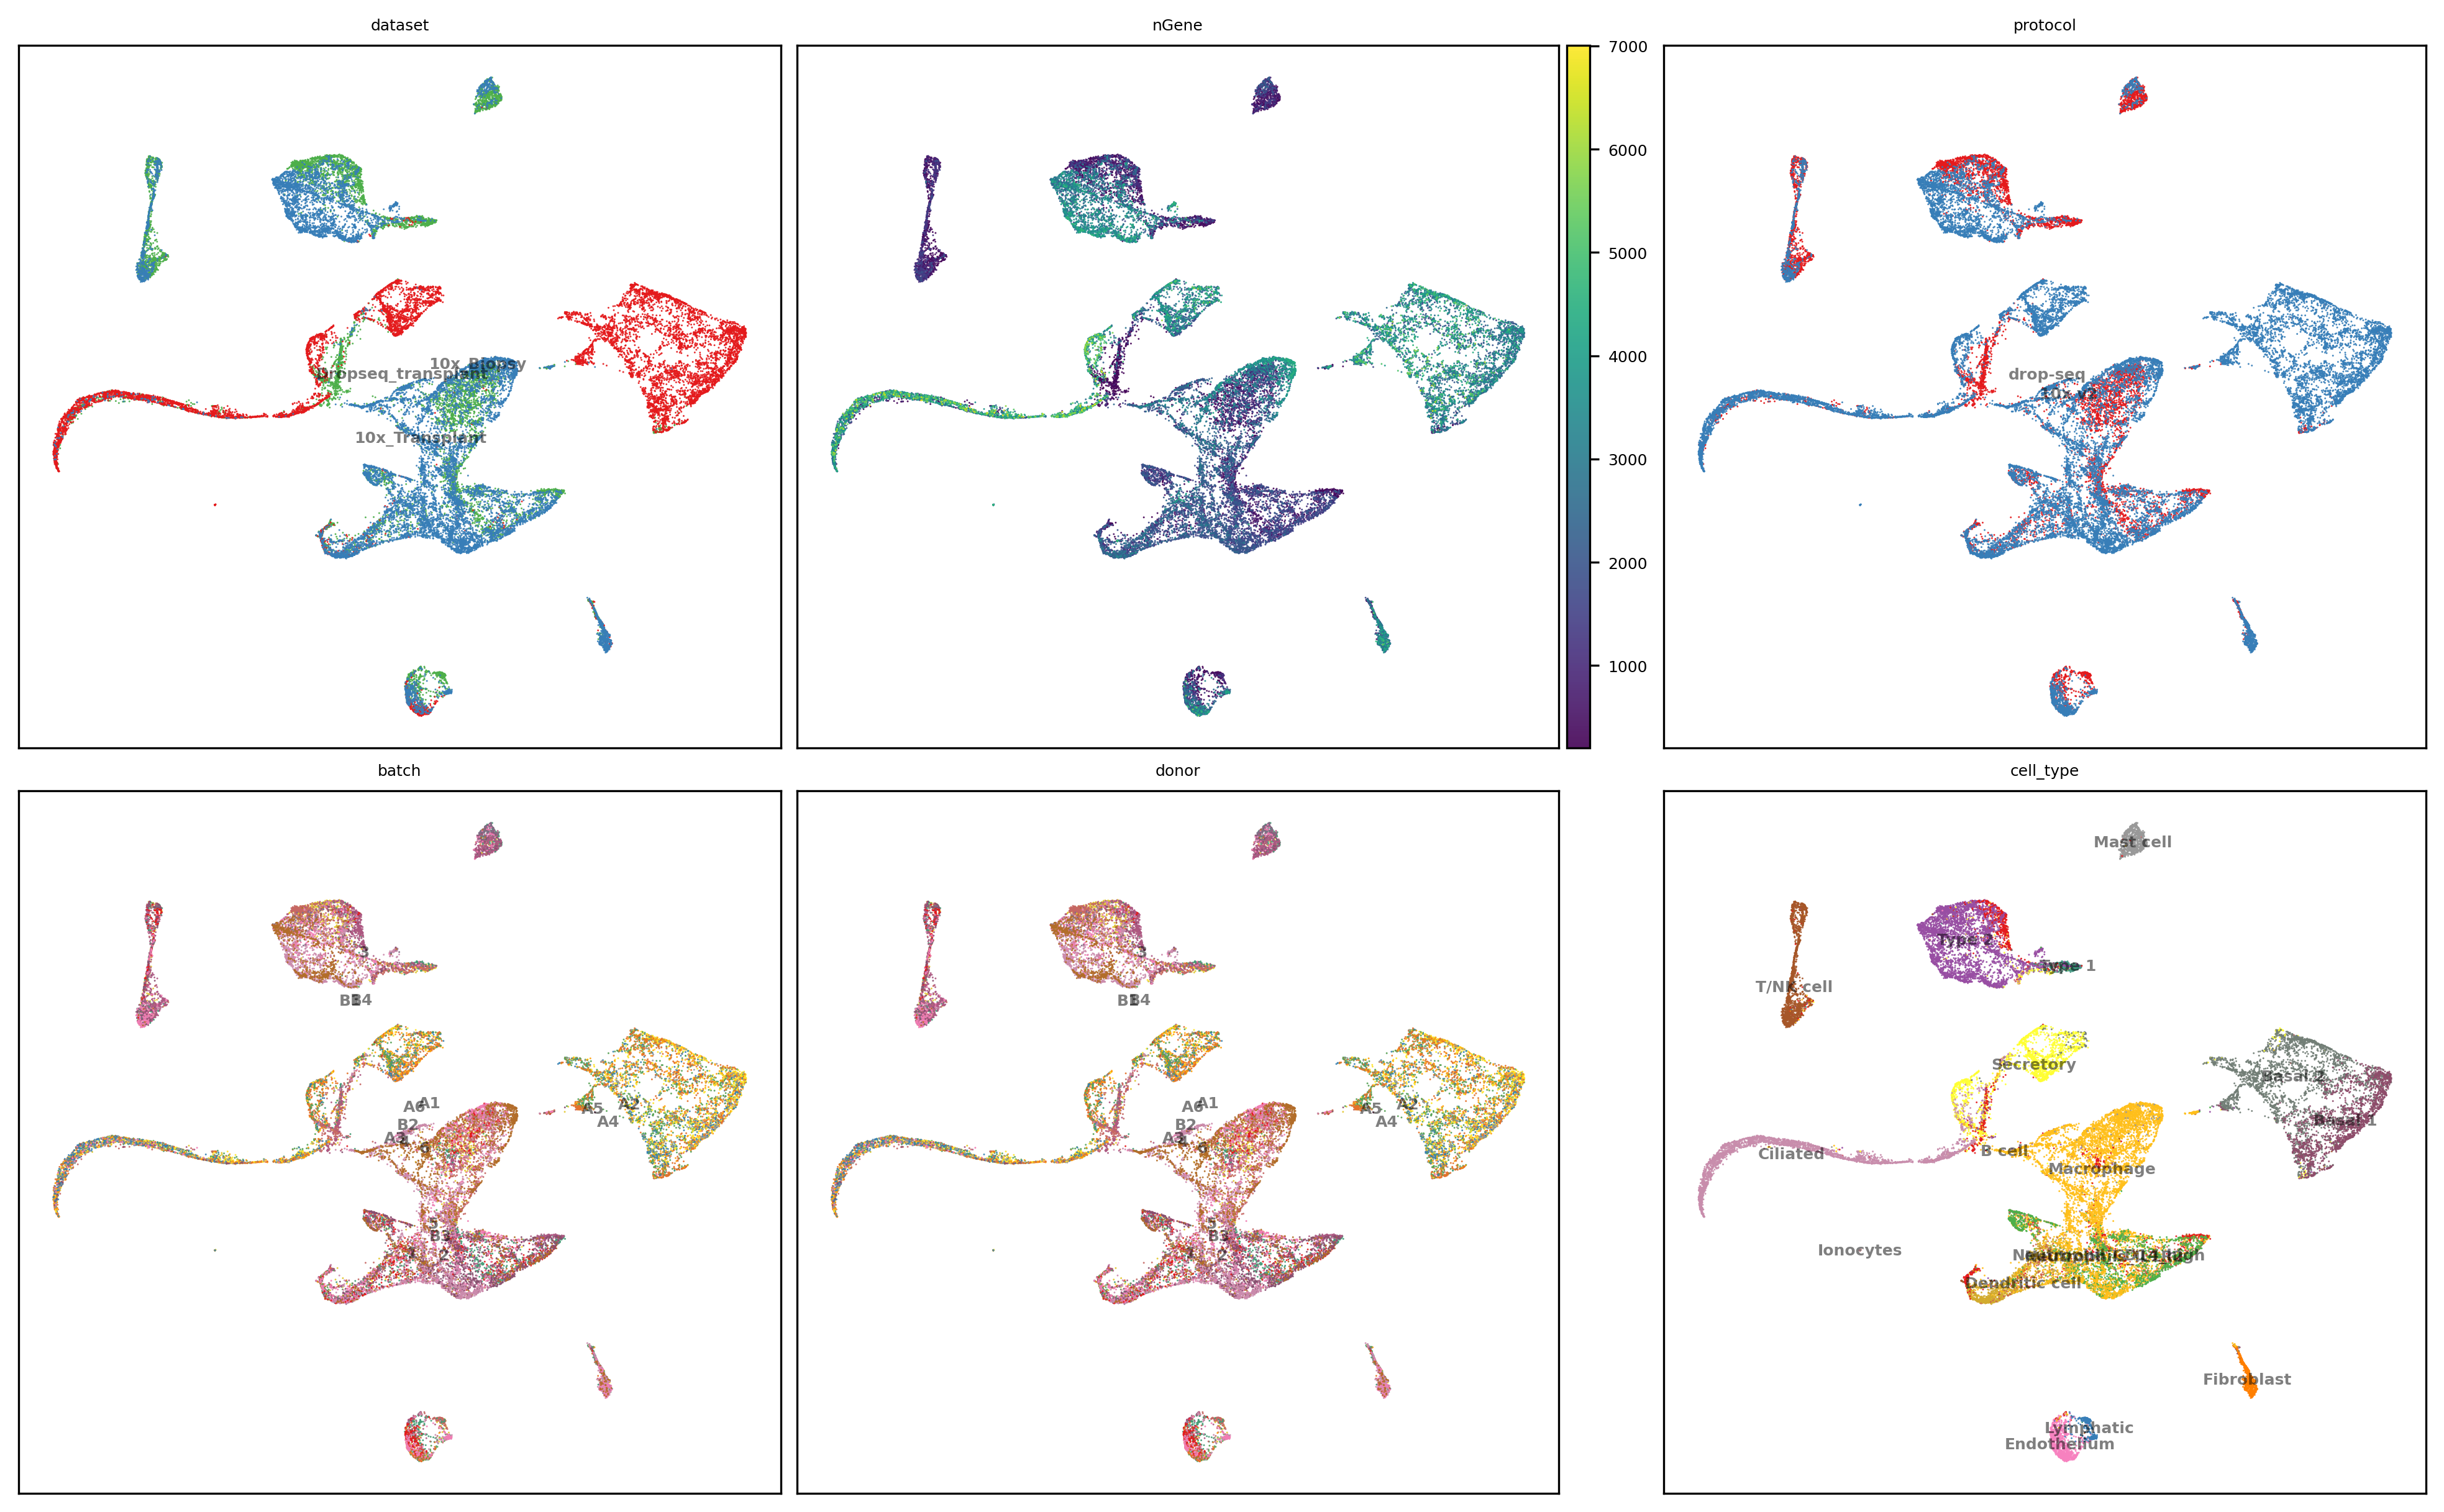

In [12]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=6, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Concord-decoder

In [ ]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      use_decoder=True,
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-decoder'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=6, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

## Concord-ant

In [ ]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      use_decoder=False,
                      use_classifier=True,
                      class_key = 'cell_type',
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-classifier'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['dataset', 'nGene', 'protocol', 'batch', 'donor', 'cell_type']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=300, ncols=3, font_size=6, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [ ]:
adata.obsm['Unintegrated_UMAP'] = adata.obsm['X_umap']

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['protocol', 'batch', 'cell_type']
basis_types = ['UMAP']
font_size=8
point_size=0.5
alpha=0.8
show_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']
figsize=(1.8*len(show_keys),2)
ncols = len(show_keys)
nrows = 1
pal = {'state':'tab10'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1
legend_loc = 'upper right'

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        legend_loc=legend_loc,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix if legend_loc == None else file_suffix+'_legend',
        save_format='pdf'
    )


## Benchmarking

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord', 'Concord-decoder', 'Concord-classifier', "scANVI"]
latent_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']

In [ ]:
latent_keys = ['Concord', 'Concord-decoder', 'Concord-classifier']

In [ ]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

In [ ]:
import pandas as pd
show_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']
show_keys = ['Concord', 'Concord-decoder', 'Concord-classifier']
scib_scores = bm.get_results(min_max_scale=False)
scib_scores = scib_scores.loc[show_keys+['Metric Type']]
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(scib_scores, pal='viridis', pal_agg='viridis', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 4), dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [ ]:
obsm_filename = save_dir / f"obsm_{file_suffix}.h5"
ccd.ul.save_obsm_to_hdf5(adata, obsm_filename)
print(f"Saved obsm to {obsm_filename}")